In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from numpy import log

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df1=pd.read_csv("/content/drive/MyDrive/data_set_etherium/full_data__6__2017.csv")
df2=pd.read_csv("/content/drive/MyDrive/data_set_etherium/full_data__6__2018.csv")
df3=pd.read_csv("/content/drive/MyDrive/data_set_etherium/full_data__6__2019.csv")
df4=pd.read_csv("/content/drive/MyDrive/data_set_etherium/full_data__6__2020.csv")
df5=pd.read_csv("/content/drive/MyDrive/data_set_etherium/full_data__6__2021.csv")

In [48]:
DF=pd.concat([df1,df2,df3,df4,df5])

#### **<span>Dataset Structure</span>** 
> 1.  timestamp - A timestamp for the minute covered by the row.
> 2.  Asset_ID - An ID code for the cryptoasset.
> 3.  Count - The number of trades that took place this minute.
> 4.  Open - The USD price at the beginning of the minute.
> 5.  High - The highest USD price during the minute.
> 6.  Low - The lowest USD price during the minute.
> 7.  Close - The USD price at the end of the minute.
> 8.  Volume - The number of cryptoasset u units traded during the minute.
> 9.  VWAP - The volume-weighted average price for the minute.
> 10. Target - 15 minute residualized returns. 

In [49]:
DF.head()

,Unnamed: 0,timestamp,Asset_ID,Asset_Name,Weight,Count,Open,High,Low,Close,Volume,VWAP,Target
0,9178560,1509667200,6,NaN,NaN,14.0,283.12,283.65,283.11,283.65,16.08390,661.31,0.003767
1,9178561,1509667260,6,NaN,NaN,18.0,283.65,283.65,283.65,283.65,19.43202,661.85,0.003795
2,9178562,1509667320,6,NaN,NaN,0.0,283.65,283.65,283.65,283.65,0.00000,NaN,0.005200
3,9178563,1509667380,6,NaN,NaN,0.0,283.65,283.65,283.65,283.65,0.00000,NaN,0.006833
4,9178564,1509667440,6,NaN,NaN,1.0,283.65,283.65,283.65,283.65,1.00000,661.85,0.007138


## Data Preprocessing


### 1- Index dataFrame using DateTime converted Timestamp



In [50]:
DF.index=DF.timestamp.apply(lambda x:datetime.fromtimestamp(x))

### 2- Drop Irrelevant Columns

In [51]:
DF.drop(["timestamp","Asset_ID","Asset_Name","Weight","Unnamed: 0","Target"],axis=1,inplace=True)

### 3- Resample Data

Due to large dataset, 

In [101]:
DF.describe()

,Count,Open,High,Low,Close,Volume,VWAP
count,2.230499e+06,2.230499e+06,2.230499e+06,2.230499e+06,2.230499e+06,2.230499e+06,2.198866e+06
mean,6.410408e+02,8.183031e+02,8.200619e+02,8.166761e+02,8.183035e+02,1.011812e+03,1.089205e+03
std,1.181647e+03,1.064239e+03,1.065273e+03,1.063116e+03,1.064241e+03,1.956440e+03,1.938444e+03
min,0.000000e+00,8.178300e+01,8.265000e+01,8.056000e+01,8.176683e+01,0.000000e+00,8.177974e+01
25%,1.350000e+02,1.908033e+02,1.912400e+02,1.904400e+02,1.908069e+02,2.012555e+02,1.896237e+02
50%,2.700000e+02,3.118100e+02,3.123300e+02,3.111700e+02,3.118129e+02,4.851199e+02,3.759260e+02
75%,6.710000e+02,8.204730e+02,8.238000e+02,8.170450e+02,8.204617e+02,1.082215e+03,9.455851e+02
max,6.625300e+04,4.865220e+03,4.868000e+03,4.861380e+03,4.865220e+03,1.120268e+05,1.134689e+04


based on **Hours**

In [53]:
DF_hourly =DF.resample('60min', label='right').mean()

### 4- Check Null Values

In [54]:
DF_hourly.isnull().sum()

Count     329
Open      329
High      329
Low       329
Close     329
Volume    329
VWAP      331
dtype: int64

## 5- Fill NaN values using an interpolation method

In [55]:
DF_hourly=DF_hourly.interpolate(limit_direction="forward") 

In [56]:
DF_hourly.isnull().sum()

Count     0
Open      0
High      0
Low       0
Close     0
Volume    0
VWAP      0
dtype: int64

## 6- Plot the multivariate time serie

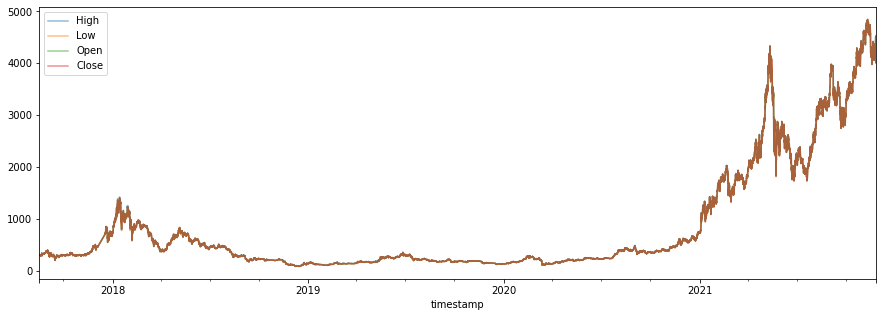

In [57]:
DF_hourly[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)


### The four variables have almost the same behaviour troughout time and based on this assumption in this project we will only use on one of them  in order to build a model that will  predict future values (close)

### The plot shows also that there is no important information to use before 2020, due to that we will **just** use the data from 2020

# hourly

In [58]:
DF_hourly= DF_hourly.loc["2020":]

## 2- Check *Stationarity*

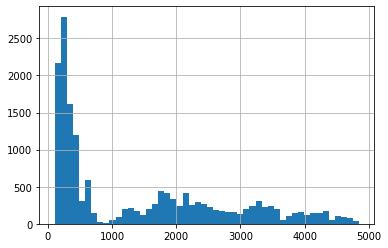

In [59]:
DF_hourly.High.hist(bins=50)

## Check Mean and Variance

In order to check stationarity, we can start by looking at the mean and the standard deviation of the time serie.
We will split the original timeserie to 10 timeseries and check the Mean and STD

In [60]:
from statistics import stdev

def check_stats(df):
  split = int(np.round(df.shape[0]/10,0))
  mean=[]
  std=[]
  for i in range(10):
      mean.append(df['Close'].iloc[(i*split):(i*split)+split].mean())
      std.append(stdev(df['Close'].iloc[(i*split):(i*split)+split]))
  return pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

In [61]:
check_stats(DF_hourly)

,mean,std
0,199.130955,45.756778
1,167.916543,31.725421
2,235.221731,19.803684
3,378.831286,32.442724
4,460.898000,85.852848
5,1207.125758,429.206711
6,1963.226158,353.142072
7,2670.998959,624.618674
8,2894.733801,618.193574
9,3900.955070,569.212420


Measures are clearly different in each chunk now we can assume it's a not stationary serie.


## Dickey-Fuller Test

 we will make the Augmented Dickey-Fuller test, using 5% as significance level and declaring the following hypothesis:

H0= Serie corresponds to non-stationary type.
H1= Serie corresponds to stationary type.

In [62]:
def dickey_fuller(df):
  result = adfuller(df)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

In [63]:
dickey_fuller(DF_hourly['Close'])

ADF Statistic: -0.062395
p-value: 0.953058
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


As p-value is greater than 0.05 we can't  reject the null hypothesis, therefore there is not enough evidence to reject that we are working with a non-stationary series. Let's apply the log transformation to the serie and test again.

In [64]:
dickey_fuller(log(DF_hourly['Close']))

ADF Statistic: -0.725715
p-value: 0.839976
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### It is clear that it is not a stationary time 


In [65]:
DF_hourly

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2020-01-01 00:00:00,113.533333,128.963485,129.290407,128.425667,128.962919,228.931752,128.963067
2020-01-01 01:00:00,112.796610,128.740371,129.064159,128.289153,128.738209,284.910154,128.740126
2020-01-01 02:00:00,219.100000,129.624342,130.000526,129.188167,129.647553,543.081950,129.638419
2020-01-01 03:00:00,140.466667,130.570633,130.916704,130.173167,130.576236,334.585177,130.574789
2020-01-01 04:00:00,149.783333,130.202711,130.499820,129.769333,130.193646,317.734746,130.196188
...,...,...,...,...,...,...,...
2021-11-26 20:00:00,459.816667,4074.282667,4077.211167,4071.676333,4074.907000,183.782577,9507.189833
2021-11-26 21:00:00,583.550000,4081.381333,4084.649167,4078.547333,4081.941333,199.531710,9523.843611
2021-11-26 22:00:00,586.416667,4103.430667,4106.409500,4099.812833,4102.572500,196.843068,9573.746500


We can use all different approches to forcast starting by making the serie stationary and then apply AR models or using Machine or deep learning Techniques.
For our example, we used LSTM in order to forecast.

In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(DF_hourly) 

In [68]:
DF_hourly = pd.DataFrame(scaled,columns=DF_hourly.columns, index=DF_hourly.index)

## Model

In [70]:
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Prepare Train/Validation/Test Datasets

Firstly, we will define a new dataset equal to the existing one, but omitting the last 20 records, later we will use the model to predict such values.

In [81]:
new_df_h=DF_hourly['Close'].iloc[:-20]


Create Training Dataset (80%) of the total records with a window of size 10

In [120]:
window=10
train_len = math.ceil(len(new_df_h)*0.8)
train_data = new_df_h[0:train_len]

def create_ds(train_data):
  X_train=[]
  Y_train=[]

  for i in range(window, len(train_data)):
      X_train.append(train_data[i-window:i])
      Y_train.append(train_data[i])
  X_train, Y_train= np.array(X_train), np.array(Y_train)
  return X_train,Y_train

timestamp
2020-01-01 00:00:00    0.005241
2020-01-01 01:00:00    0.005194
2020-01-01 02:00:00    0.005386
2020-01-01 03:00:00    0.005582
2020-01-01 04:00:00    0.005501
                         ...   
2021-07-09 23:00:00    0.432942
2021-07-10 00:00:00    0.432681
2021-07-10 01:00:00    0.436074
2021-07-10 02:00:00    0.433724
2021-07-10 03:00:00    0.429601
Freq: 60T, Name: Close, Length: 13348, dtype: float64

In [93]:
X_train, Y_train= create_ds(train_data)

Create Validation Dataset (20%) of the total records 

In [95]:
X_val, Y_val = create_ds(new_df_h[train_len-window:])

Our mode is simple with one LSTM layer with relu activation function and one hidden fully connected layer, the optimizer used is Adam, number of epochs=10, batch_size=10 and loss function=Mean squared error:

In [84]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


## Model Validation

In [85]:
prediction = model.predict(X_val)

In [86]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

Train rmse: 0.006563642743297881
Validation rmse: 0.005999475059640344


Both errors are low, our model can generalize well

In [87]:
valid = pd.DataFrame(new_df_h[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,Close,Predictions
timestamp,,
2021-07-10 04:00:00,0.428624,0.429236
2021-07-10 05:00:00,0.427061,0.427319
2021-07-10 06:00:00,0.423958,0.425470
2021-07-10 07:00:00,0.425189,0.422681
2021-07-10 08:00:00,0.424710,0.422552
...,...,...
2021-11-26 00:00:00,0.932771,0.932241
2021-11-26 01:00:00,0.931065,0.936925
2021-11-26 02:00:00,0.927502,0.936471


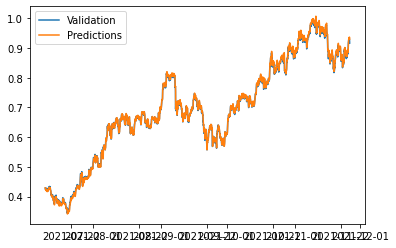

In [88]:
plt.plot(valid[['Close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

we can see a simple plot showing both curves, in which the prediction seems meaningful

## Train and Validation Plot

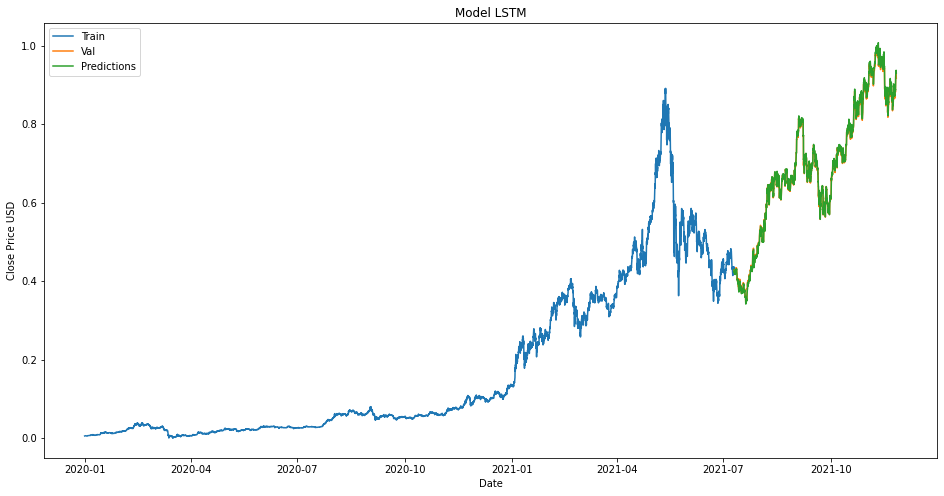

In [89]:
train = new_df_h[:train_len]
valid = pd.DataFrame(new_df_h[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

## Predict Future Values (unseen Test Values)

In [132]:
X_test, Y_test = create_ds(DF_hourly['Close'].iloc[-200:])

In [133]:
lstm_valid_test = model.predict(X_test)
test = pd.DataFrame(DF_hourly['Close'].iloc[-190:])
test['Predictions']=lstm_valid_test

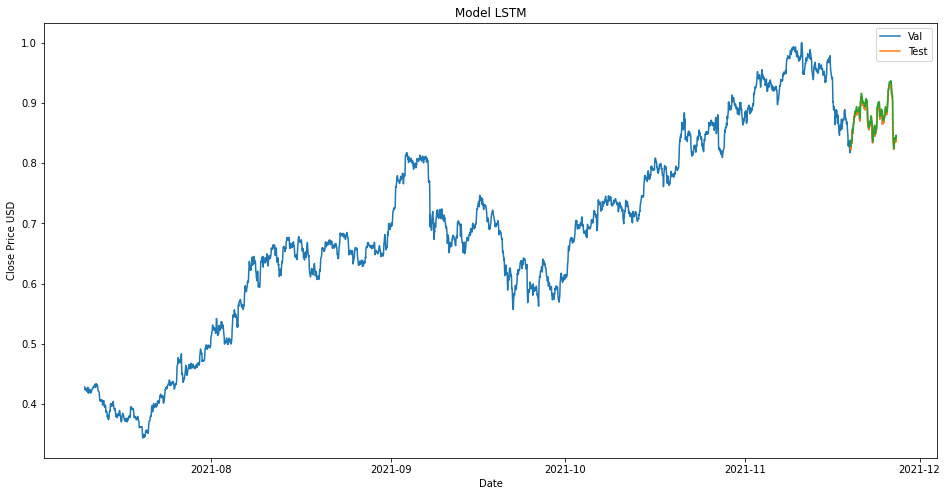

In [134]:
plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(valid[['Close']])
plt.plot(test)
plt.legend(['Val','Test'])
plt.show()